In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "9g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('exploration') \
    .getOrCreate()

24/10/01 12:12:32 WARN Utils: Your hostname, Alans-MacBook-Air-4.local resolves to a loopback address: 127.0.0.1; using 10.12.103.213 instead (on interface en0)
24/10/01 12:12:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/01 12:12:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
tbl_merchants = spark.read.parquet('../data/curated/tbl_merchants')
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "\\s+", " "))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", except appliances", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "rent al", "rental"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ":", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " -", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " shops", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " services", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " service", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " and", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", sales", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " ,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",]", "]"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\[", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\]", ""))

tbl_merchants.show(truncate=False)

+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+----------------------------------------------------------------+-----+-----+
|merchant_name                       |tags                                                                                                             |merchant_abn|tags1                                                           |tags2|tags3|
+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+----------------------------------------------------------------+-----+-----+
|Felis Limited                       |[[furniture, home furnishings and equipment shops, and manufacturers, except appliances], [e], [take rate: 0.18]]|10023283211 |furniture, home furnishings, equipment, manufacturers           |e    |0.18 |
|Arcu Ac Orci Corporation   

In [23]:
tbl_merchants.where(F.col("merchant_abn") == "91848160033").show()

+-------------+----+------------+-----+-----+-----+
|merchant_name|tags|merchant_abn|tags1|tags2|tags3|
+-------------+----+------------+-----+-----+-----+
+-------------+----+------------+-----+-----+-----+



+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|postcode|     gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|
+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|    2021-11-26| 79417999332|  14935|    1059280|136.06570809815838|23acbb7b-cf98-458...|    Cameron Adams|  QLD|    4563|       Male|             NULL|Phasellus At Company|[[gift, card, nov...|gift, card, novel...|    b| 4.95|        

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_50212/958697277.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lon'] = postcodes.geometry.centroid.x
/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_50212/958697277.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lat'] = postcodes.geometry.centroid.y


<Axes: >

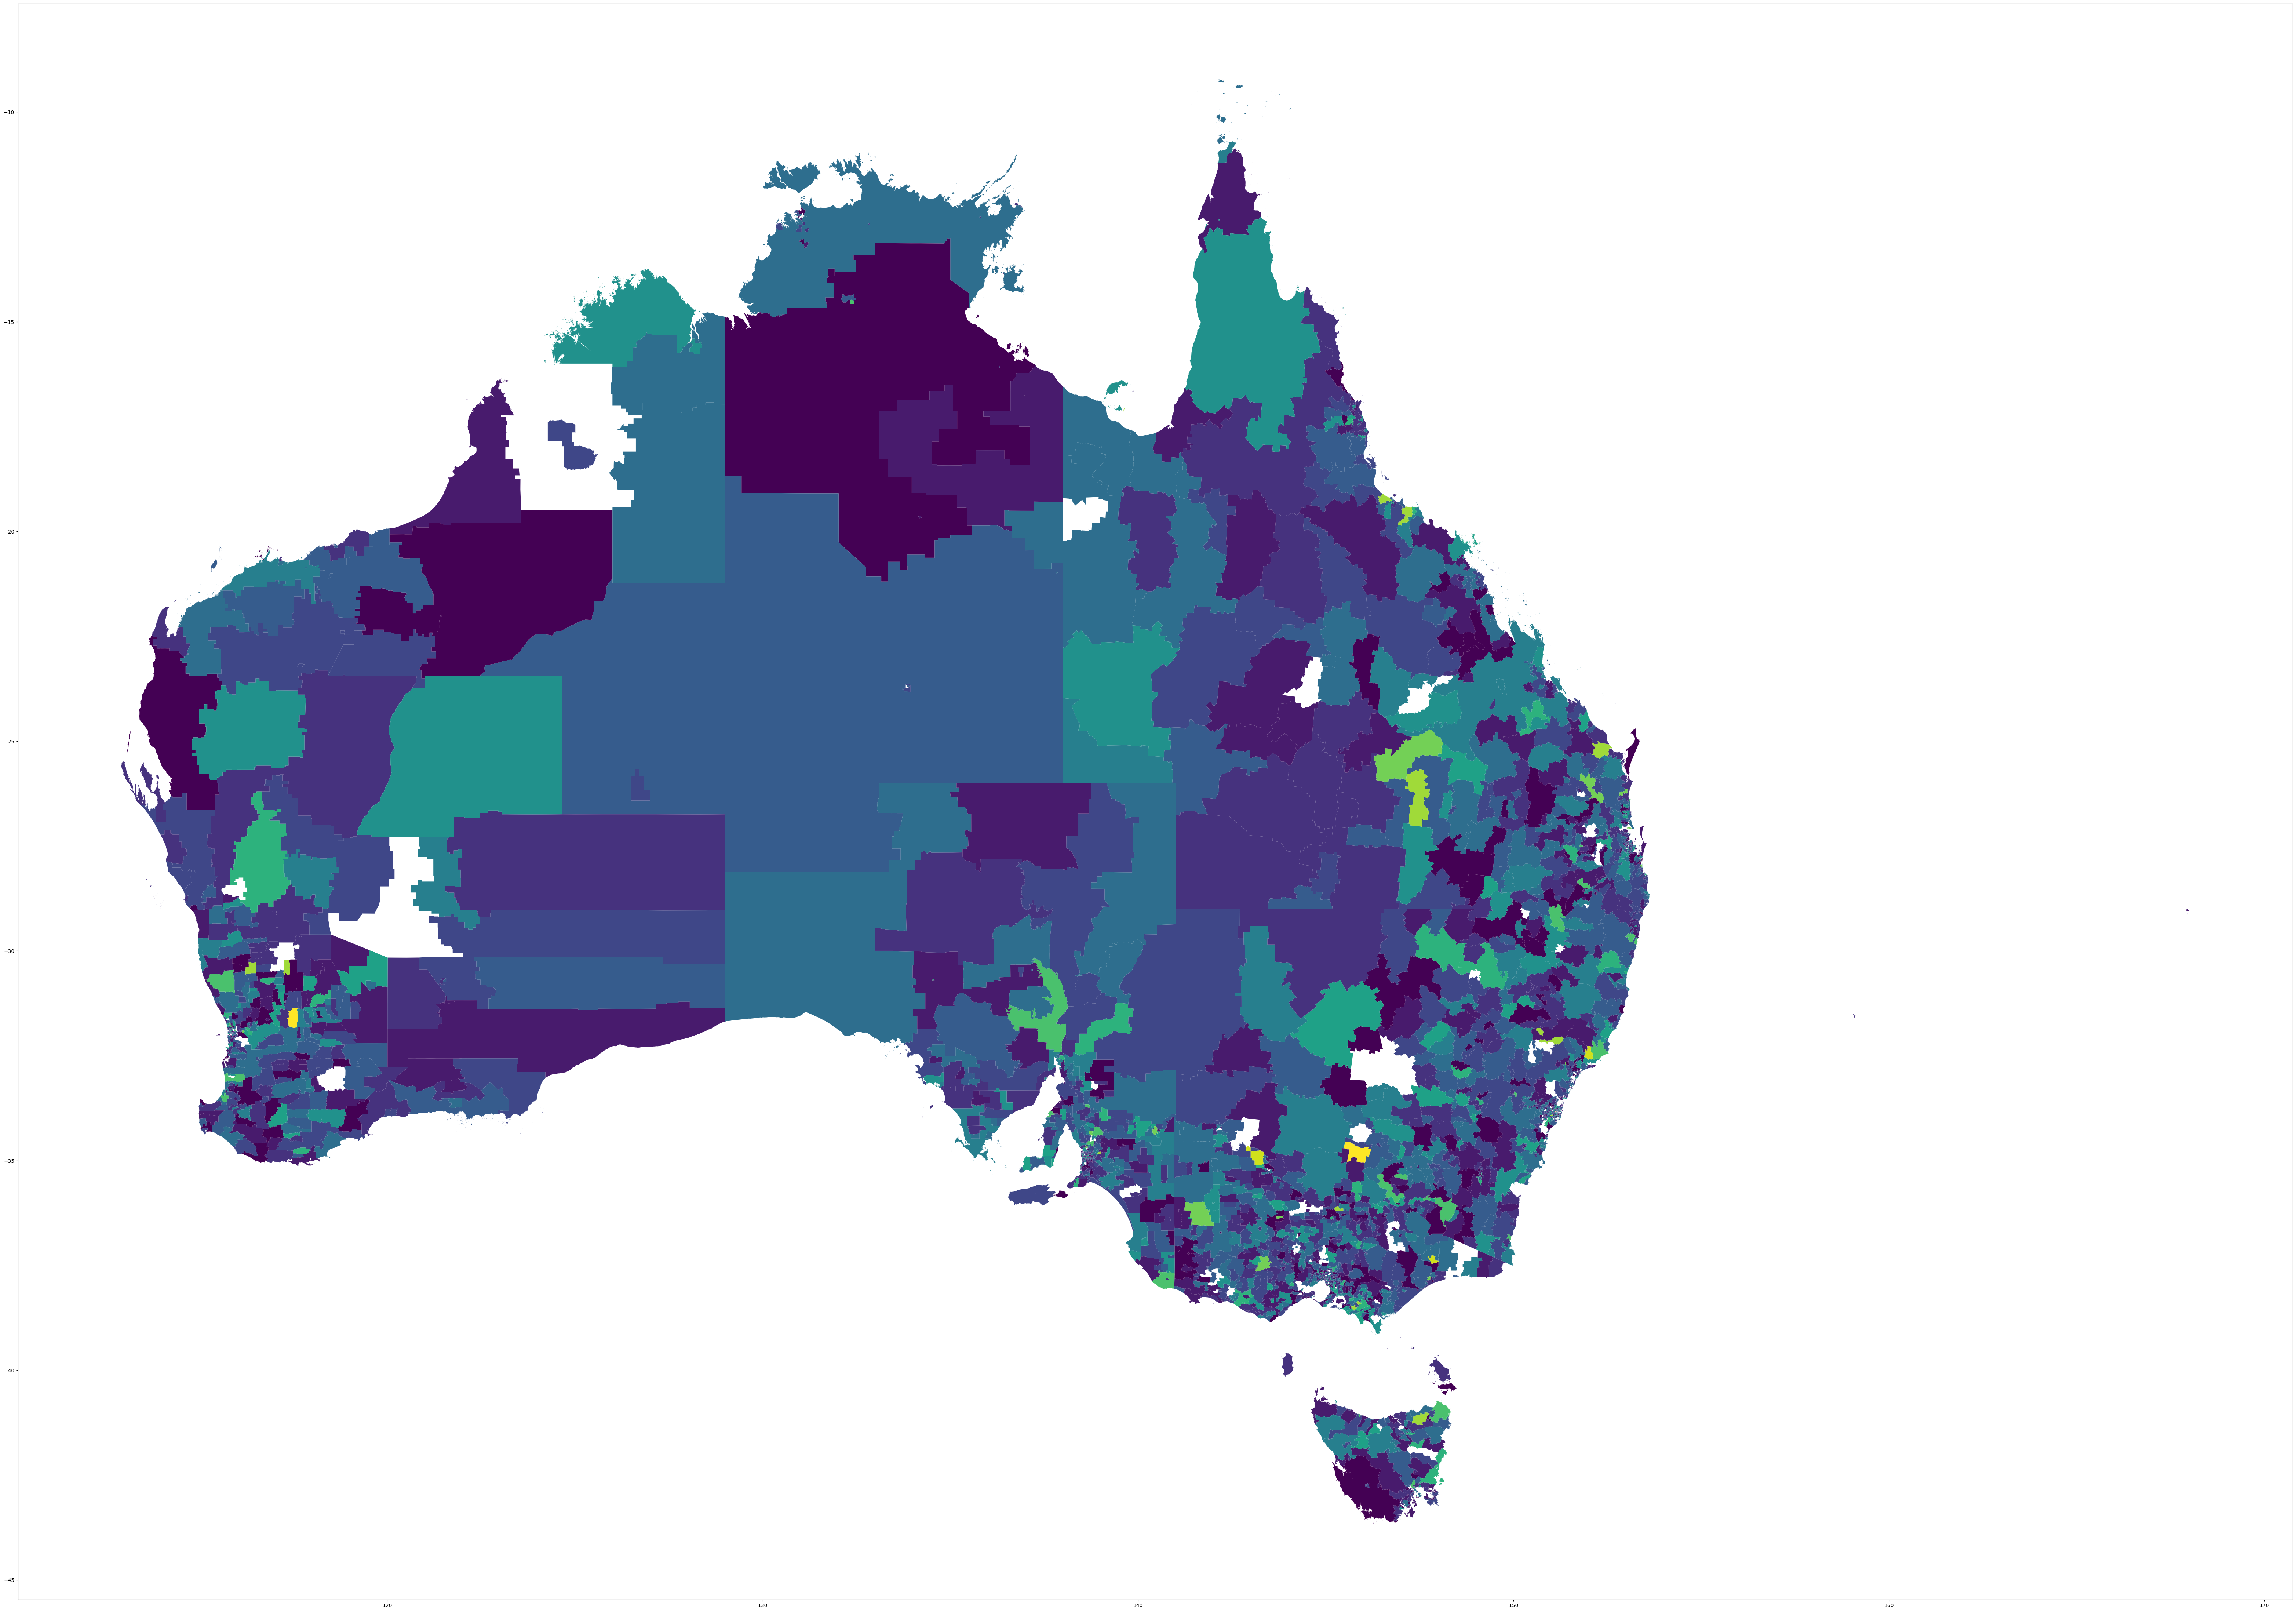

In [2]:
transactions = spark.read.parquet("../data/curated/full_transaction")
transactions.show()

# transactions_df = transactions.toPandas()

postcodes = gpd.read_file("../data/landing/POA_2021_AUST_GDA2020_SHP")
postcodes = postcodes.to_crs(epsg='4326')

postcodes['lon'] = postcodes.geometry.centroid.x
postcodes['lat'] = postcodes.geometry.centroid.y
postcodes = postcodes.drop(columns='geometry')
postcodes = postcodes.loc[:, ['POA_CODE21', 'AREASQKM21', 'SHAPE_Leng', 'SHAPE_Area', 'lon', 'lat']]
postcodes = postcodes.rename(columns={'POA_CODE21': 'postcode'})

postcodes = spark.createDataFrame(postcodes)
# postcodes.show()

transactions = transactions.join(postcodes, on='postcode')
a = transactions.where(F.col('merchant_abn') == 17678252870)
a = a.groupBy('postcode').count()
# a.show()
a = a.toPandas()


p2 = gpd.read_file("../data/landing/POA_2021_AUST_GDA2020_SHP")

p2 = p2[pd.to_numeric(p2['POA_CODE21'], errors='coerce').notnull()]
p2['POA_CODE21'] = p2['POA_CODE21'].astype('int32')
b = p2.merge(a, left_on='POA_CODE21', right_on='postcode')
# b = b.groupby('POA_CODE21').count()
b.plot('count', figsize=(80, 80))

In [110]:
merchant_fraud = spark.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud.show()

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
| 31334588839|    2021-12-26| 38.36165958070444|
| 23686790459|    2021-12-10|  79.4543441508535|
| 14827550074|    2021-11-26| 46.45775596795885|
| 31334588839|    2021-11-26| 36.20971272078342|
| 19492220327|    2021-12-18|33.819672154331755|
| 31334588839|    2021-11-29|35.386213297375505|
| 14827550074|    2021-12-05| 43.85519494291279|
| 19492220327|    2021-11-18|32.193139919494016|
| 93260930990|    2021-11-30| 37.87197154172081|
| 90918180829|    2021-09-16| 36.62001350882694|
| 83199298021|    2022-02-27|26.025158824861773|
| 83199298021|    2022-02-17| 25.77998392496447|
| 94311056026|    20

In [6]:
merchant_fraud = merchant_fraud.withColumn("fraud_probability", F.col("fraud_probability").cast(DoubleType()))
merchant_fraud.select("merchant_abn", "fraud_probability").groupBy("merchant_abn") \
    .agg(
        F.count("*").alias("count"),
        F.mean("fraud_probability").alias("mean_fraud_probability")
    ).show(1000)

+------------+-----+----------------------+
|merchant_abn|count|mean_fraud_probability|
+------------+-----+----------------------+
| 67264251405|    1|     18.21089142894488|
| 43083074133|    1|     48.66890735193894|
| 99989036621|    1|     18.21089142894488|
| 31334588839|   12|     32.36111871776698|
| 11590404675|    1|    29.607818240092094|
| 29674997261|    1|     44.43787807900268|
| 14827550074|    4|     42.00056688395546|
| 83220249221|    1|     63.51245947057463|
| 76767266140|    1|    29.539733207182703|
| 59258669983|    1|    30.180090258715534|
| 94493496784|    1|     30.57903215900633|
| 80089686333|    1|      67.5058112247036|
| 35909341340|    1|     29.13305311007307|
| 19492220327|    8|    31.958306675667547|
| 18737319630|    1|     72.73069736562613|
| 11149063370|    3|     53.28693336242285|
| 57564805948|    1|    31.268145098828853|
| 21439773999|    1|    28.504479048104585|
| 18158387243|    2|     29.02968340431819|
| 82999039227|    1|      94.134

In [13]:
fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).to_pandas_on_spark()
fraud_transactions.plot.scatter('dollar_value', 'merchant_fraud_probability')

/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/.venv/lib/python3.11/site-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/.venv/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


<Axes: xlabel='dollar_value', ylabel='merchant_fraud_probability'>

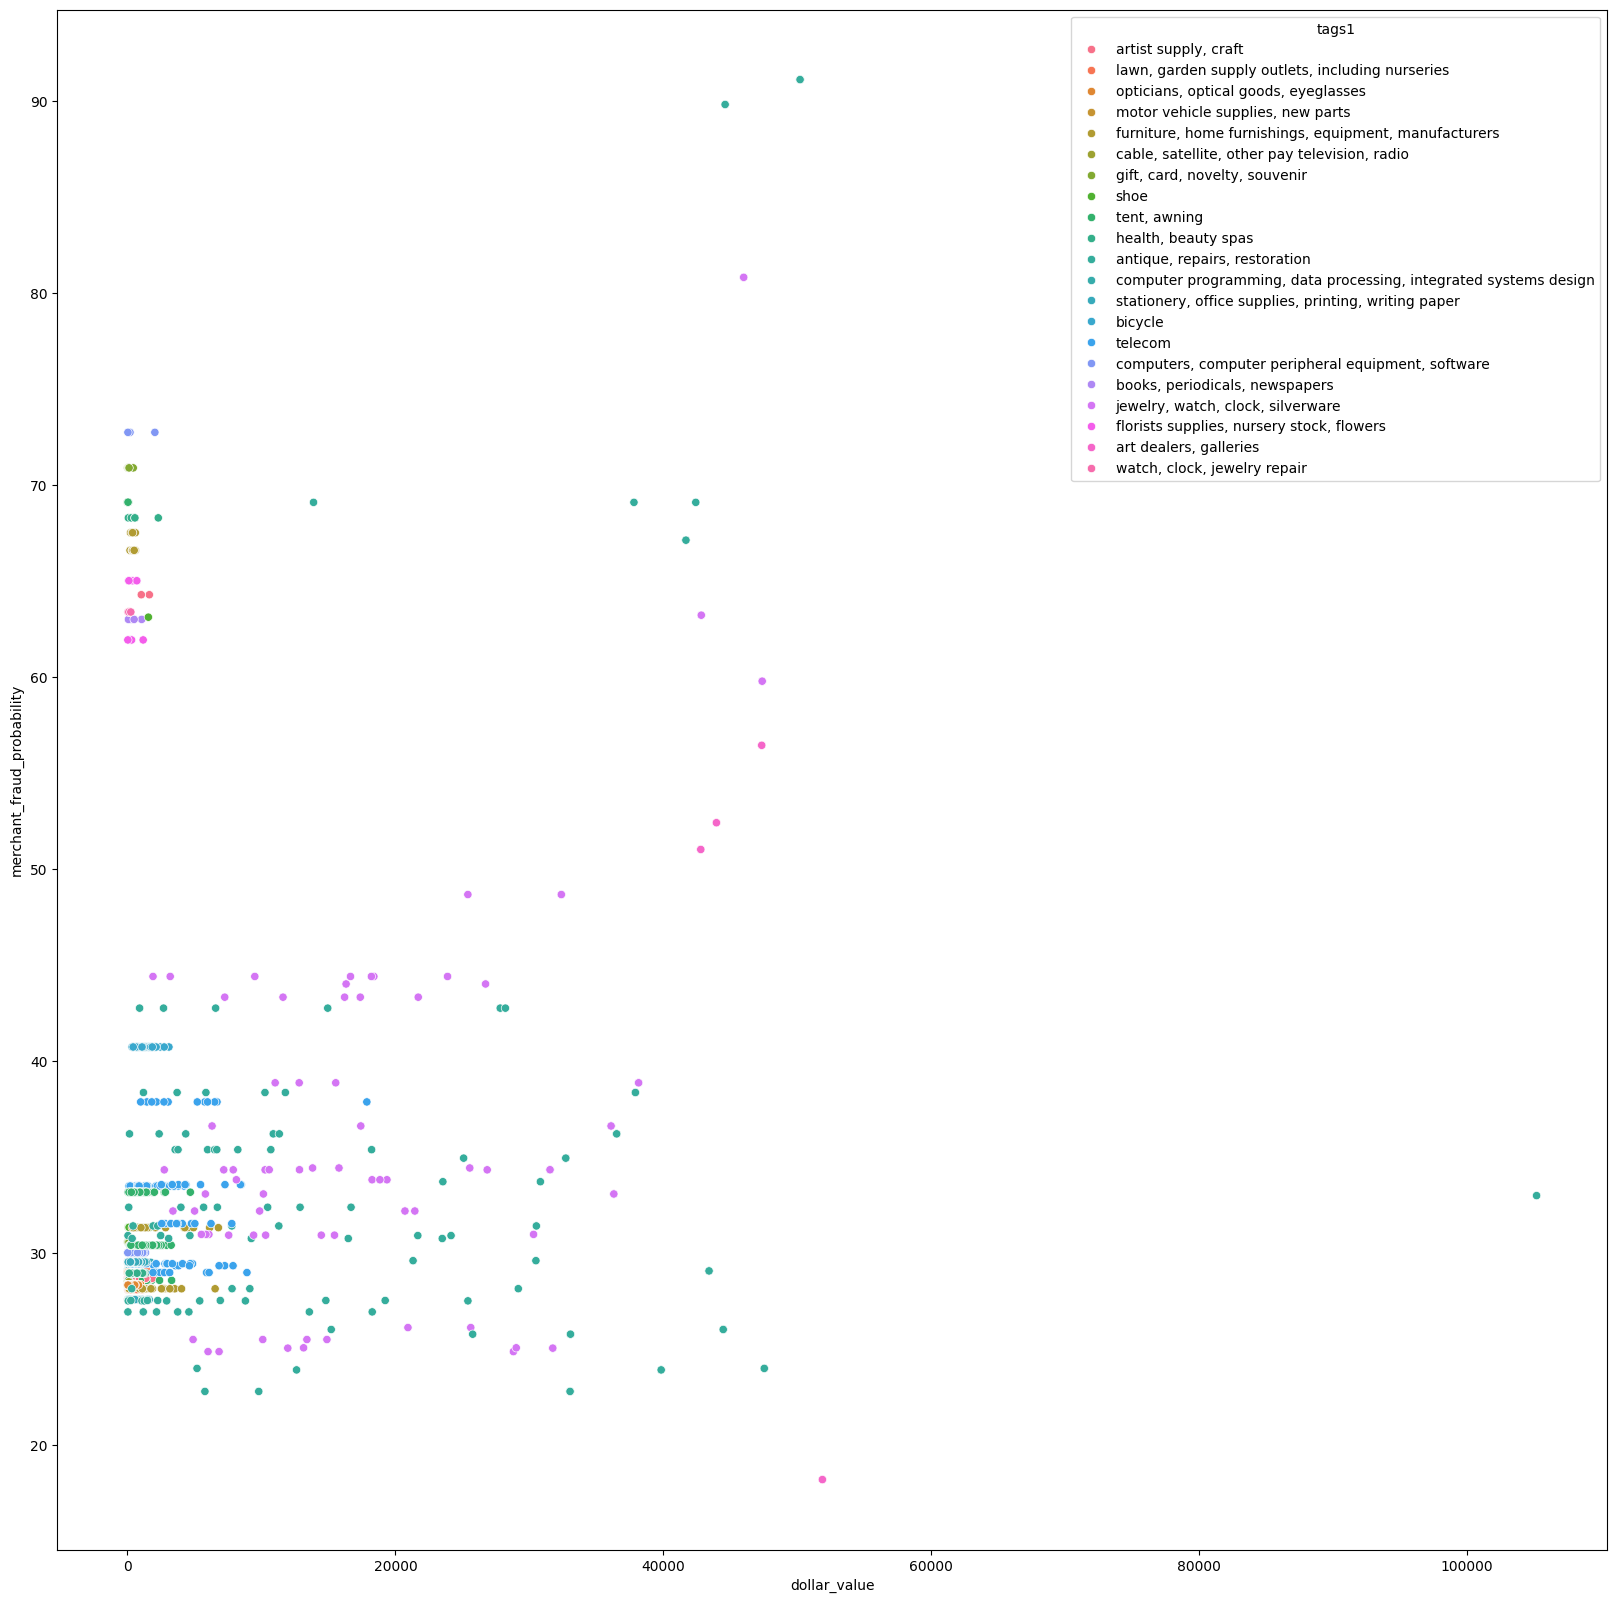

In [61]:
fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()
plt.figure(figsize=(20, 20))
sns.scatterplot(fraud_transactions, x='dollar_value', y='merchant_fraud_probability', hue='tags1')

# Impute merchant fraud probabilities

RMSE: 2.733005032856987


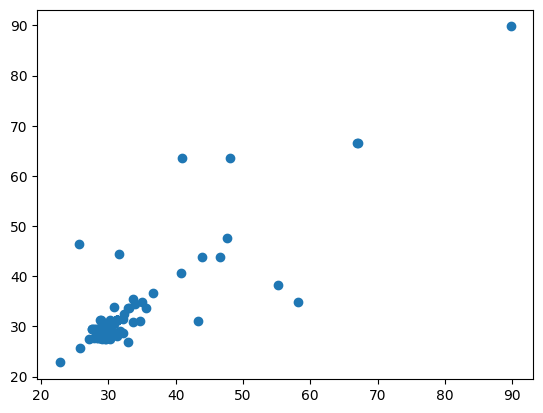

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()
categories = transactions.select('tags1').distinct().toPandas().dropna().astype("string")['tags1'].to_list()

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [13]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [7]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [4]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [15]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = fraud_transactions.drop('merchant_fraud_probability', axis=1)
y = fraud_transactions['merchant_fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test)
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [14]:
# Refit pipeline on full dataset to make predictions
pipeline.fit(X, y)

full_transactions = pd.read_parquet("../data/curated/full_transaction")

full_transactions.loc[
    full_transactions['merchant_fraud_probability'].isna(),
    'merchant_fraud_probability'
] = pipeline.predict(
    full_transactions[full_transactions['merchant_fraud_probability'].isna()]
)
full_transactions.to_parquet("../data/curated/full_transactions_with_merchant_prob.parquet")
full_transactions.head()

order_datetime  merchant_abn  user_id consumer_id  dollar_value  \
0     2021-08-20   62191208634    18478      651338     63.255849   
1     2021-08-20   15549624934        2      179208    130.350528   
2     2021-08-20   64403598239    18479      467663    120.158606   
3     2021-08-20   60956456424        3     1194530    136.678520   
4     2021-08-20   94493496784    18479      467663     72.963166   

                               order_id   consumer_name state  postcode  \
0  949a63c8-29f7-4ab0-ada4-99ac50a88952     James Smith   TAS    7001.0   
1  6a84c3cf-612a-4574-835b-144a47353eff      Mary Smith   NSW    2782.0   
2  b10dcc33-e53f-4254-863c-de5266810cbc  Sandra Schultz   TAS    7010.0   
3  0f09c5a5-784e-4477-b049-8ee4dd069b7b   Jill Jones MD    NT     862.0   
4  f6c78c1a-4600-4c5f-8e97-6e9eb534b586  Sandra Schultz   TAS    7010.0   

   gender  fraud_probability                  merchant_name  \
0    Male                NaN  Cursus Non Egestas Foundation   
1  Female                NaN             Commodo Associates   
2  Female                NaN      Lobortis Ultrices Company   
3  Female                NaN        Ultricies Dignissim LLP   
4  Female                NaN  Dictum Phasellus In Institute   

                                                tags  \
0  [[furniture, home furnishings and equipment sh...   
1  [[opticians, optical goods, and eyeglasses], [...   
2  [[music shops - musical instruments, pianos, a...   
3  [[gift, card, novelty, and souvenir shops], [b...   
4  [[gift, card, novelty, and souvenir shops], [a...   

                                               tags1 tags2  tags3  \
0  furniture, home furnishings, equipment, manufa...     c   2.17   
1               opticians, optical goods, eyeglasses     c   2.76   
2    music, musical instruments, pianos, sheet music     a   6.31   
3                      gift, card, novelty, souvenir     b   4.69   
4                      gift, card, novelty, souvenir     a   5.65   

   merchant_fraud_probability  
0                   57.368987  
1                   29.526565  
2                   28.504479  
3                   30.579032  
4                   30.579032

RMSE: 6.929752929768359


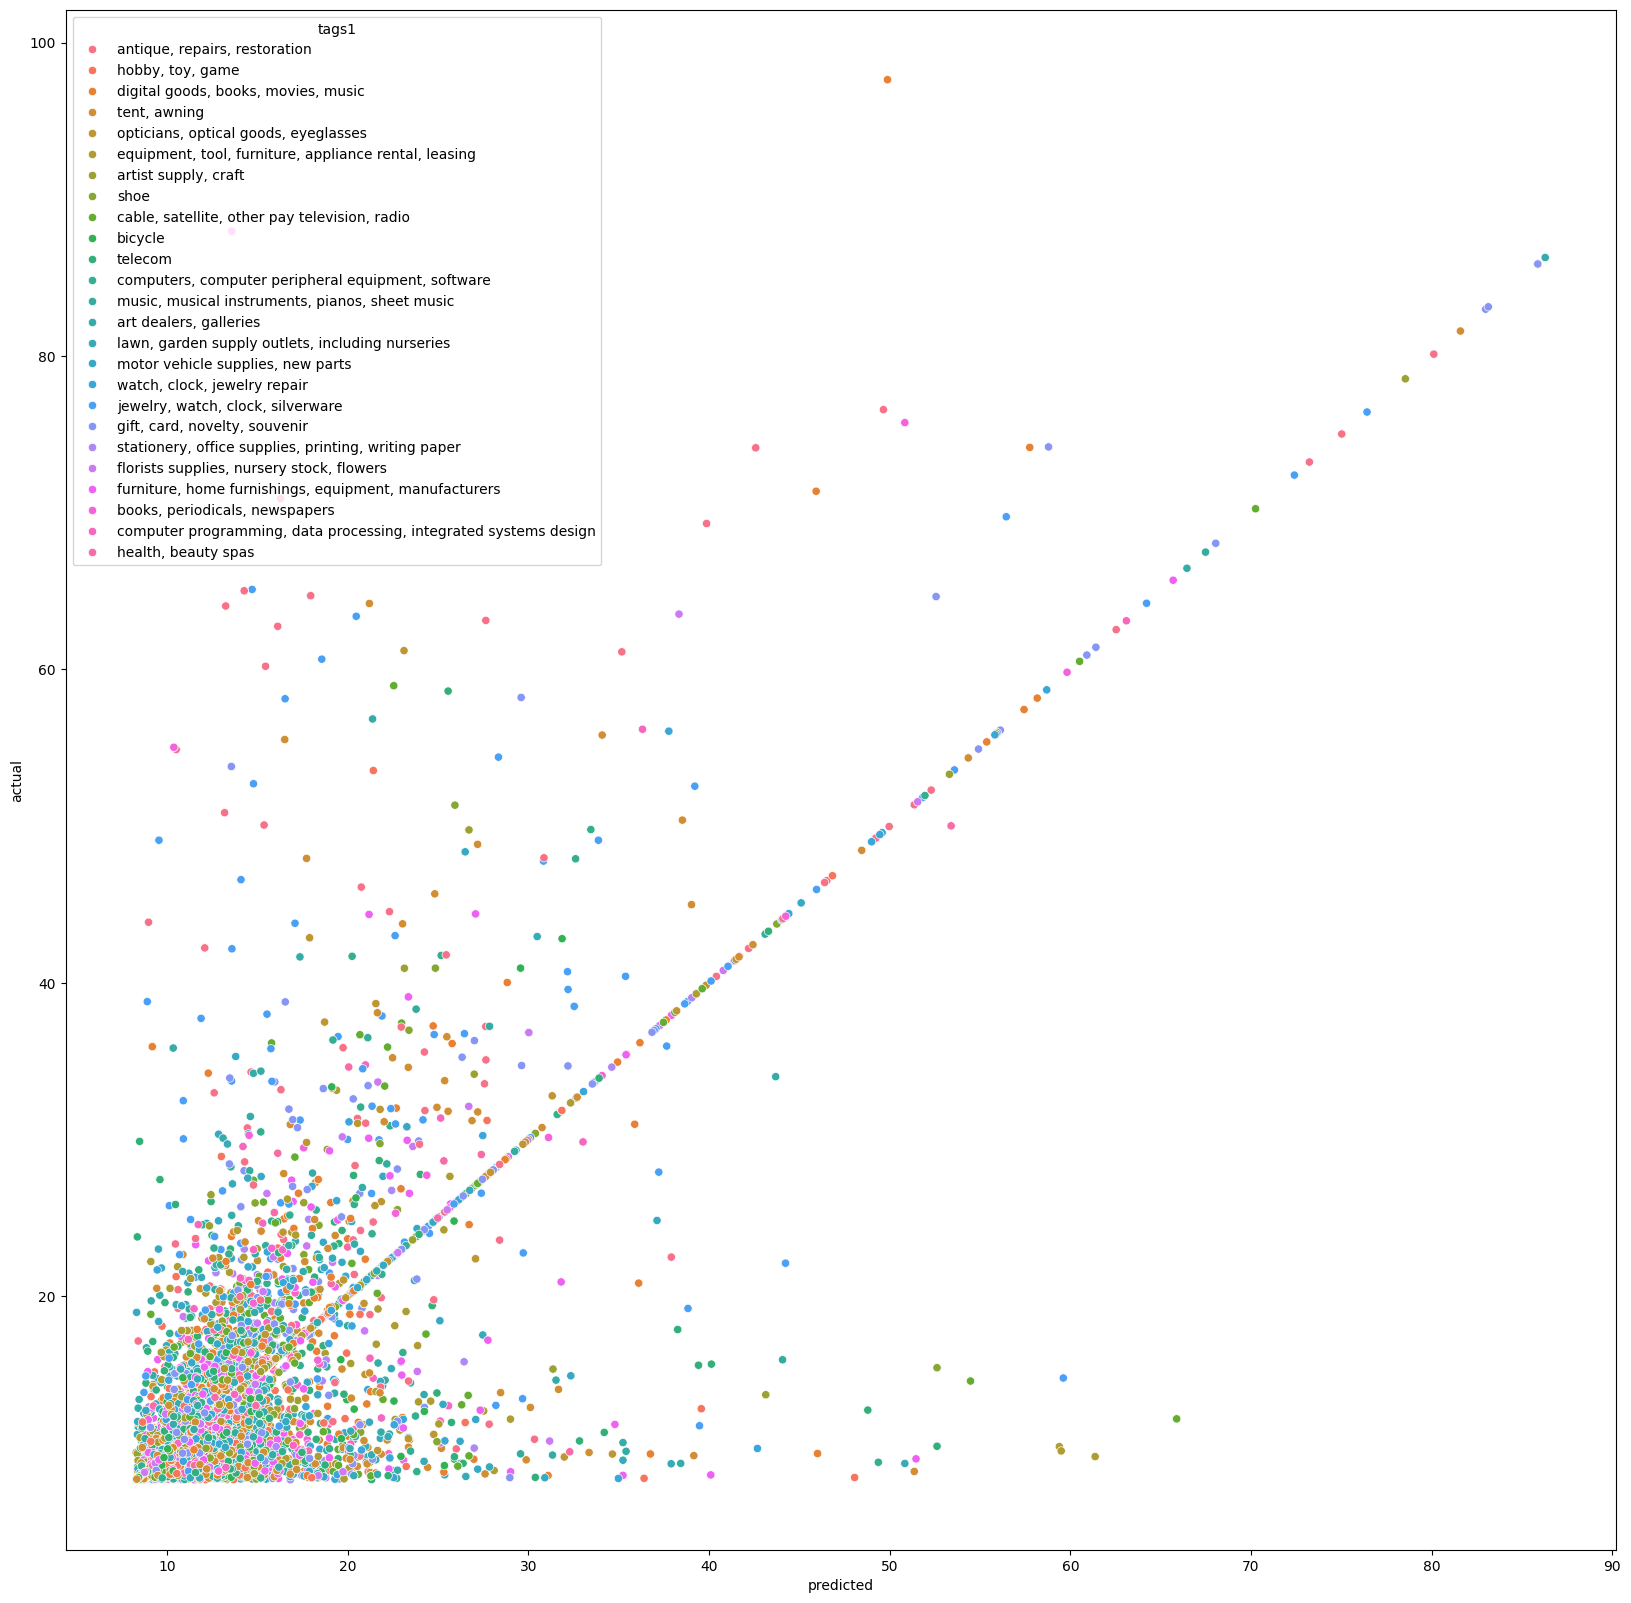

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

fraud_transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()
# fraud_transactions = fraud_transactions[fraud_transactions['tags1'] == 'furniture, home furnishings, equipment, manufacturers']

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [13]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [7]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [4]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [15]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=int(math.sqrt(len(fraud_transactions)) / 2), weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = fraud_transactions.drop('fraud_probability', axis=1)
y = fraud_transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

combined = X_test
combined['predicted'] = pipeline.predict(X_test)
combined['actual'] = y_test
plt.figure(figsize=(20, 20))
sns.scatterplot(combined, x='predicted', y='actual', hue='tags1')

print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

# plt.figure(figsize=(20, 20))
# sns.scatterplot(fraud_transactions, x='dollar_value', y='fraud_probability', hue='tags1')

In [36]:
import torch
from torch import nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# transactions.write.mode("overwrite").parquet("temp.parquet")
df = pd.read_parquet("temp.parquet")
df = df[~df['fraud_probability'].isna()]
df = df[~df['tags3'].isna()]
df['fraud_probability'] /= 100.0

label_encoders = {}
for col in ['state', 'gender', 'tags1', 'tags2']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
df[['tags3', 'dollar_value']] = scaler.fit_transform(df[['tags3', 'dollar_value']])

X_categorical = torch.tensor(df[['state', 'gender', 'tags1', 'tags2']].values, dtype=torch.long)
X_continuous = torch.tensor(df[['tags3', 'dollar_value']].values, dtype=torch.float32)
y = torch.tensor(df['fraud_probability'].values, dtype=torch.float32).unsqueeze(1)

class NeuralNetwork(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super(NeuralNetwork, self).__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        self.emb_dropout = nn.Dropout(0.2)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)
        
        self.fc1 = nn.Linear(sum([size for _, size in embedding_sizes]) + n_cont, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, x_categorical, x_continuous):
        x = [emb_layer(x_categorical[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_dropout(x)
        
        x_cont = self.batch_norm_cont(x_continuous)
        x = torch.cat([x, x_cont], 1)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(self.fc3(x))
        return x

embedding_sizes = [(df[col].nunique(), min(64, (df[col].nunique() + 1) // 2)) for col in ['state', 'gender', 'tags1', 'tags2']]
model = NeuralNetwork(embedding_sizes, X_continuous.shape[1])

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

batch_size = 32
num_epochs = 10
num_batches = len(X_categorical) // batch_size

for epoch in range(num_epochs):
    for i in range(0, len(X_categorical), batch_size):
        X_cat_batch = X_categorical[i:i+batch_size]
        X_cont_batch = X_continuous[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_cont_batch)
        # print(outputs)
        loss = criterion(outputs, y_batch)
        # print(loss)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

print(model)
y_pred = model(X_categorical, X_continuous).detach().numpy().flatten()
y_actual = y.detach().numpy().flatten()
print(root_mean_squared_error(y_pred, y_actual))


Epoch 1, Loss: 0.4411807656288147
Epoch 2, Loss: 0.44069430232048035
Epoch 3, Loss: 0.44017523527145386
Epoch 4, Loss: 0.4402707517147064
Epoch 5, Loss: 0.44031813740730286
Epoch 6, Loss: 0.4401019811630249
Epoch 7, Loss: 0.4404136836528778
Epoch 8, Loss: 0.4407522678375244
Epoch 9, Loss: 0.44021546840667725
Epoch 10, Loss: 0.4404754638671875
NeuralNetwork(
  (embeddings): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(3, 2)
    (2): Embedding(25, 13)
    (3): Embedding(5, 3)
  )
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (batch_norm_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (out): Sigmoid()
)
0.08043105


In [ ]:
print(root_mean_squared_error(model(X_categorical, X_continuous), y))


In [29]:
df = pd.read_parquet("temp.parquet")
df = df[~df['fraud_probability'].isna()]
# df = df[~df['tags3'].isna()]
len(df)

67143

In [17]:
torch.tensor(df['fraud_probability'].values).unsqueeze(1)
print(torch.isnan(X_categorical).any())
print(torch.isnan(X_continuous).any())
print(torch.isnan(y).any())

tensor(False)
tensor(True)
tensor(False)


In [21]:
df = pd.read_parquet("temp.parquet")
df = df[~df['fraud_probability'].isna()]
df[df['tags3'].isna()]['f']

postcode order_datetime  merchant_abn  user_id consumer_id  \
273           3918     2021-11-26   91848160033    11642      818018   
594           2659     2021-11-27   29566626791    16430     1484750   
947           3918     2021-11-28   56638395137    20624      678997   
1684          2142     2021-11-25   99271509353     9720     1107704   
1968          2866     2021-11-23   11240426404    17420      211974   
...            ...            ...           ...      ...         ...   
11809217      2423     2021-03-29   87982339334    19206     1037098   
11810543      3134     2021-03-01   11400713351      254      426437   
11818257      2340     2021-02-28   29227046551     4351     1047752   
11818307      3929     2021-02-28   82999039227    17365      873547   
11845621      3825     2021-03-16   11358147682    10876      953841   

          dollar_value                              order_id  \
273          26.529606  480e3df4-d7f3-47f5-89d7-8efbeb4c785b   
594          48.917789  186ec1ca-10e3-47ba-b123-2364e5aea9f9   
947        4396.269012  bd4f66a8-b3e1-4c1d-bfeb-d4a79672a6cd   
1684       3409.053861  2c337d6b-4462-4b9e-b636-25a9077b0ad6   
1968         68.939433  b3d4611a-167c-44ce-ab93-309152fa6890   
...                ...                                   ...   
11809217   6988.387595  4c88d27d-395f-4e2f-a06c-a92bc389097d   
11810543   5596.060179  3127f632-4fd4-4dfe-8c92-f8192f9f670c   
11818257   6233.707584  4af17458-c857-4911-8c8f-ed5213990cb2   
11818307  14817.038643  da991ba2-978a-4974-9b01-18069ae4cc57   
11845621   7626.566709  e4221348-133b-41ef-bc8d-bfc3777a4c8d   

              consumer_name state       gender  ...  tags tags1 tags2 tags3  \
273            Adam Cabrera   VIC         Male  ...  None  None  None   NaN   
594         Courtney Warner   NSW       Female  ...  None  None  None   NaN   
947            Scott Brooks   VIC         Male  ...  None  None  None   NaN   
1684      Christine Harding   NSW       Female  ...  None  None  None   NaN   
1968        Jennifer Austin   NSW       Female  ...  None  None  None   NaN   
...                     ...   ...          ...  ...   ...   ...   ...   ...   
11809217    Diane Schroeder   NSW       Female  ...  None  None  None   NaN   
11810543       John Sanchez   VIC         Male  ...  None  None  None   NaN   
11818257    Hannah Gonzalez   NSW       Female  ...  None  None  None   NaN   
11818307    Alyssa Sandoval   VIC  Undisclosed  ...  None  None  None   NaN   
11845621     Lauren Hensley   VIC  Undisclosed  ...  None  None  None   NaN   

         merchant_fraud_probability  AREASQKM21  SHAPE_Leng  SHAPE_Area  \
273                             NaN     17.2160    0.258945    0.001774   
594                             NaN    367.5445    1.316072    0.036604   
947                             NaN     17.2160    0.258945    0.001774   
1684                            NaN     10.9833    0.238433    0.001070   
1968                            NaN   1198.7089    2.844113    0.115669   
...                             ...         ...         ...         ...   
11809217                        NaN   1346.2284    2.437422    0.129000   
11810543                        NaN     22.8758    0.342883    0.002340   
11818257                        NaN   3352.9983    6.487131    0.317438   
11818307                        NaN     55.1320    0.478126    0.005690   
11845621                        NaN   1871.9394    4.324962    0.191788   

                 lon        lat  
273       145.169516 -38.336720  
594       146.857306 -35.703870  
947       145.169516 -38.336720  
1684      151.018255 -33.835340  
1968      148.960539 -33.009741  
...              ...        ...  
11809217  152.259070 -32.373659  
11810543  145.237181 -37.791883  
11818257  150.974567 -31.235804  
11818307  144.978282 -38.458342  
11845621  146.328299 -37.912216  

[7308 rows x 22 columns]

In [ ]:
df = pd.read_parquet("temp.parquet")

In [74]:
fraud_transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()
fraud_transactions['greater_than_3000'] = fraud_transactions['dollar_value'] > 3000
fraud_transactions.head()

order_datetime  merchant_abn  user_id consumer_id  dollar_value  \
0     2021-11-26   43725628716       58      838663   2684.361418   
1     2021-11-26   45629217853       58      838663      0.196078   
2     2021-11-26   73499119023       58      838663      9.260984   
3     2021-11-26   30623214058       69      640907    111.911650   
4     2021-11-26   79417999332       69      640907     54.895609   

                               order_id   consumer_name state  postcode  \
0  52133cb6-4950-44ce-97d7-a9476855bda8  Adam Velazquez   NSW    2403.0   
1  e5b1880d-fb88-4fd5-8305-27eeebebd2ac  Adam Velazquez   NSW    2403.0   
2  a576a634-dcd0-4450-a26e-77e86358cb10  Adam Velazquez   NSW    2403.0   
3  362fc544-e9c0-4493-94b8-c6b68580ad9e    Terry Martin    SA    5168.0   
4  3c246238-a15f-429c-ba63-2f3eaa90aba4    Terry Martin    SA    5168.0   

  gender  fraud_probability            merchant_name  \
0   Male           9.241198  Proin Velit Sed Limited   
1   Male           9.241198         Lacus Consulting   
2   Male           9.241198      Nisi Dictum Company   
3   Male          15.645332             Mauris Eu PC   
4   Male          15.645332     Phasellus At Company   

                                                tags  \
0  [[hobby, toy and game shops], [a], [take rate:...   
1  [[gift, card, novelty, and souvenir shops], [a...   
2  [[watch, clock, and jewelry repair shops], [a]...   
3  [[gift, card, novelty, and souvenir shops], [c...   
4  [[gift, card, novelty, and souvenir shops], [b...   

                           tags1 tags2  tags3  merchant_fraud_probability  \
0               hobby, toy, game     a   5.53                         NaN   
1  gift, card, novelty, souvenir     a   6.98                         NaN   
2   watch, clock, jewelry repair     a   5.56                         NaN   
3  gift, card, novelty, souvenir     c   2.06                         NaN   
4  gift, card, novelty, souvenir     b   4.95                         NaN   

   greater_than_3000  
0              False  
1              False  
2              False  
3              False  
4              False

In [14]:
plt.figure(figsize=(20, 20))
# sns.scatterplot(fraud_transactions[(fraud_transactions['dollar_value'] < 10000) & (fraud_transactions['tags1'] == 'telecom')], x='dollar_value', y='fraud_probability', hue='tags1')
# sns.scatterplot(fraud_transactions[(fraud_transactions['dollar_value'] < 10000) & (fraud_transactions['tags1'] == 'gift, card, novelty, souvenir')], x='dollar_value', y='fraud_probability', hue='tags1')
# sns.scatterplot(fraud_transactions[(fraud_transactions['dollar_value'] < 10000) & (fraud_transactions['tags1'] == 'furniture, home furnishings, equipment, manufacturers')], x='dollar_value', y='fraud_probability', hue='tags3')
sns.scatterplot(fraud_transactions[(fraud_transactions['dollar_value'] < 10000)], x='dollar_value', y='fraud_probability', hue='merchant_abn')
# sns.scatterplot(fraud_transactions, x='dollar_value', y='fraud_probability', hue='order_datetime', alpha=0.3)

TypeError: Data source must be a DataFrame or Mapping, not <class 'pyspark.pandas.frame.DataFrame'>.

<Figure size 2000x2000 with 0 Axes>

In [112]:
transactions.show()


+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|postcode|     gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|
+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|    2021-11-26| 79417999332|  14935|    1059280|136.06570809815838|23acbb7b-cf98-458...|    Cameron Adams|  QLD|    4563|       Male|             NULL|Phasellus At Company|[[gift, card, nov...|gift, card, novel...|    b| 4.95|        

In [82]:
fraud_transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()
fraud_transactions.sort_values(by="consumer_id").head(10)

order_datetime  merchant_abn  user_id consumer_id  dollar_value  \
10354     2021-11-24   83323591742    12606     1000031    950.494189   
10353     2021-11-24   46012371285    12606     1000031    522.343473   
10352     2021-11-24   77990807356    12606     1000031   5738.752030   
10355     2021-11-24   45466221547    12606     1000031      1.426416   
10356     2021-11-24   43073797016    12606     1000031     11.445890   
63673     2021-05-31   49839448838     8622     1000051    131.103630   
63672     2021-05-31   33296649772     8622     1000051    219.807676   
63671     2021-05-31   46693373183     8622     1000051   5338.897224   
48402     2021-09-02   61050921768     2917     1000067   1843.422740   
34973     2021-10-29   80551528183     2917     1000067   3442.438746   

                                   order_id consumer_name state  postcode  \
10354  bc79ff0f-90f1-4255-8493-9ac1b8f915fb  Pamela Olsen   NSW    2177.0   
10353  21649521-4e78-4e5c-b437-b77d79ea986a  Pamela Olsen   NSW    2177.0   
10352  f9f9ab56-4b37-4f88-8e8b-78689d9acad0  Pamela Olsen   NSW    2177.0   
10355  8d03f794-d236-486f-8673-c30ed866f627  Pamela Olsen   NSW    2177.0   
10356  c843da35-7433-488a-a526-00370833241d  Pamela Olsen   NSW    2177.0   
63673  5d86ef91-8a86-42d2-b9c9-1e04fd720d5a  Calvin Scott   QLD    4053.0   
63672  689b977a-5896-48ea-8dce-560d2b3e479f  Calvin Scott   QLD    4053.0   
63671  49c60c02-1c16-4ba1-947a-4c36c33e747c  Calvin Scott   QLD    4053.0   
48402  85cdef0d-2105-466b-85b3-4fd3f8f68963  Michelle Fox    WA    6623.0   
34973  e2cdc18a-fd8f-4fc3-a635-11a77e67272b  Michelle Fox    WA    6623.0   

       gender  fraud_probability                  merchant_name  \
10354  Female          24.695501            Eget Dictum Limited   
10353  Female          24.695501               A Ultricies Inc.   
10352  Female          24.695501        Natoque Penatibus Corp.   
10355  Female          24.695501                         Eu LLC   
10356  Female          24.695501      Molestie Arcu Corporation   
63673    Male           9.745455  Enim Gravida Sit Incorporated   
63672    Male           9.745455            Nullam Lobortis Ltd   
63671    Male           9.745455                           None   
48402  Female           9.932096             Mauris Rhoncus LLP   
34973  Female          15.350052                   Ac Ipsum LLC   

                                                    tags  \
10354  [[florists supplies, nursery stock, and flower...   
10353  [[books, periodicals, and newspapers], [b], [t...   
10352                [[telecom], [b], [take rate: 3.95]]   
10355  [[computers, computer peripheral equipment, an...   
10356  [[health and beauty spas], [c], [take rate: 2....   
63673  [[music shops - musical instruments, pianos, a...   
63672             [[shoe shops], [c], [take rate: 1.80]]   
63671                                               None   
48402  [[bicycle shops - sales and service], [b], [ta...   
34973  [[tent and awning shops], [b], [take rate: 4.81]]   

                                                   tags1 tags2  tags3  \
10354          florists supplies, nursery stock, flowers     b   4.18   
10353                     books, periodicals, newspapers     b   4.87   
10352                                            telecom     b   3.95   
10355  computers, computer peripheral equipment, soft...     b   3.49   
10356                                health, beauty spas     c   2.27   
63673    music, musical instruments, pianos, sheet music     c   1.85   
63672                                               shoe     c   1.80   
63671                                               None  None    NaN   
48402                                            bicycle     b   4.78   
34973                                       tent, awning     b   4.81   

       merchant_fraud_probability  
10354                         NaN  
10353                         NaN  
10352                         NaN  
10355  

In [92]:
# len(fraud_transactions)
transactions.groupBy("merchant_abn", "tags1").count().sort("count").show(10000)

+------------+--------------------+------+
|merchant_abn|               tags1| count|
+------------+--------------------+------+
| 93267734067|jewelry, watch, c...|     1|
| 10404542215|antique, repairs,...|     1|
| 47047735645|antique, repairs,...|     1|
| 46244515644|                NULL|     1|
| 50154587122|                NULL|     1|
| 50794104497|                NULL|     1|
| 86868464441|                NULL|     1|
| 39150153670|antique, repairs,...|     1|
| 80664157260|                NULL|     1|
| 62688594508|jewelry, watch, c...|     1|
| 37145789569|                NULL|     1|
| 24212300522|jewelry, watch, c...|     2|
| 72519488277|                NULL|     2|
| 72900319608|                NULL|     2|
| 42461534060|antique, repairs,...|     2|
| 18261886835|antique, repairs,...|     2|
| 46537010521|jewelry, watch, c...|     2|
| 28311306642|antique, repairs,...|     2|
| 64094501963|antique, repairs,...|     2|
| 22853038342|antique, repairs,...|     2|
| 129595610

In [116]:
a = transactions.filter(transactions.fraud_probability.isNotNull()).groupBy('order_datetime').agg(
    F.mean('fraud_probability').alias('mean_fraud_probability'), 
    F.count("*").alias("count")
).sort('order_datetime').pandas_api()
a.plot.line('order_datetime', 'count')
# a.plot.line('order_datetime', 'mean_fraud_probability')

<Axes: xlabel='order_datetime'>

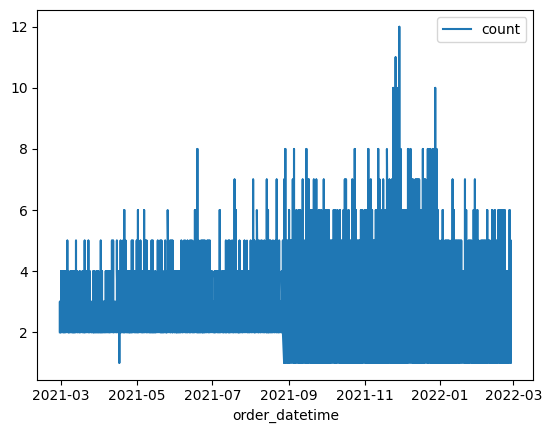

24/09/18 19:32:57 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 142058 ms exceeds timeout 120000 ms
24/09/18 19:32:57 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/18 19:33:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [144]:
a = transactions.filter(transactions.fraud_probability.isNotNull()).groupBy('consumer_id', 'order_datetime').agg(
    F.mean('fraud_probability').alias('mean_fraud_probability'), 
    F.count("*").alias("count")).sort('order_datetime').toPandas()

a.plot('order_datetime', 'fraud_probability')
# a.plot.scatter('count', 'mean_fraud_probability')

# a[a['count'] == 1].plot.hist()
# ax1 = plt.subplot(6, 1)

# plt.subplot(1, 3, 1)
# a[a['count'] == 1]['mean_fraud_probability'].hist(bins=60)
# plt.subplot(1, 3, 2)
# a[a['count'] == 2]['mean_fraud_probability'].hist(bins=60)
# plt.subplot(1, 3, 3)
# a[a['count'] == 3]['mean_fraud_probability'].hist(bins=60)
# a[a['count'] == 3]['mean_fraud_probability'].hist(bins=60)

In [118]:
transactions.filter(transactions.fraud_probability.isNotNull()).groupBy('consumer_id', 'order_datetime').agg(
    F.mean('fraud_probability').alias('mean_fraud_probability'), 
    F.count("*").alias("count")).summary().show()

24/09/18 18:35:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+----------------------+------------------+
|summary|      consumer_id|mean_fraud_probability|             count|
+-------+-----------------+----------------------+------------------+
|  count|            34765|                 34765|             34765|
|   mean| 751819.893858766|     14.94584991224032|2.3172731195167553|
| stddev|435788.2356692732|      9.39740107805538| 1.191439539154682|
|    min|          1000031|     8.287143531552802|                 1|
|    25%|         371860.0|     9.630698700892726|                 1|
|    50%|         750281.0|    11.717419444406213|                 2|
|    75%|        1129958.0|     16.15226124782765|                 3|
|    max|           999998|     99.24738020302328|                12|
+-------+-----------------+----------------------+------------------+



In [6]:
fraud_transactions.head()

order_datetime  merchant_abn  user_id consumer_id  dollar_value  \
0     2021-11-26   43725628716       58      838663   2684.361418   
1     2021-11-26   45629217853       58      838663      0.196078   
2     2021-11-26   73499119023       58      838663      9.260984   
3     2021-11-26   30623214058       69      640907    111.911650   
4     2021-11-26   79417999332       69      640907     54.895609   

                               order_id   consumer_name state  postcode  \
0  52133cb6-4950-44ce-97d7-a9476855bda8  Adam Velazquez   NSW    2403.0   
1  e5b1880d-fb88-4fd5-8305-27eeebebd2ac  Adam Velazquez   NSW    2403.0   
2  a576a634-dcd0-4450-a26e-77e86358cb10  Adam Velazquez   NSW    2403.0   
3  362fc544-e9c0-4493-94b8-c6b68580ad9e    Terry Martin    SA    5168.0   
4  3c246238-a15f-429c-ba63-2f3eaa90aba4    Terry Martin    SA    5168.0   

  gender  fraud_probability            merchant_name  \
0   Male           9.241198  Proin Velit Sed Limited   
1   Male           9.241198         Lacus Consulting   
2   Male           9.241198      Nisi Dictum Company   
3   Male          15.645332             Mauris Eu PC   
4   Male          15.645332     Phasellus At Company   

                                                tags  \
0  [[hobby, toy and game shops], [a], [take rate:...   
1  [[gift, card, novelty, and souvenir shops], [a...   
2  [[watch, clock, and jewelry repair shops], [a]...   
3  [[gift, card, novelty, and souvenir shops], [c...   
4  [[gift, card, novelty, and souvenir shops], [b...   

                           tags1 tags2  tags3  merchant_fraud_probability  
0               hobby, toy, game     a   5.53                         NaN  
1  gift, card, novelty, souvenir     a   6.98                         NaN  
2   watch, clock, jewelry repair     a   5.56                         NaN  
3  gift, card, novelty, souvenir     c   2.06                         NaN  
4  gift, card, novelty, souvenir     b   4.95                         NaN

In [105]:
len(preprocessor.fit_transform(fraud_transactions))
# np.argwhere(np.isnan(preprocessor.fit_transform(fraud_transactions)))

35

In [ ]:
from kmodes.kprototypes import KPrototypes
fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()
fraud_transactions = fraud_transactions.loc[:, ['dollar_value', 'tags1']]
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
clusters = kproto.fit_predict(X, categorical=[1, 2])

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)
# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

for s, c in zip(syms, clusters):
    print(f"Symbol: {s}, cluster:{c}")

In [95]:
fraud_transactions

order_datetime  merchant_abn  user_id consumer_id  dollar_value  \
0        2021-11-26   39649557865    14938      267457    209.127810   
1        2021-11-26   50315283629    14939      764252    575.332107   
2        2021-11-26   48534649627       15     1463076     20.288326   
3        2021-11-26   96680767841       15     1463076    376.698537   
4        2021-11-26   76767266140       17     1331093    193.802993   
...             ...           ...      ...         ...           ...   
4089     2022-01-27   90918180829    19789     1062095  36306.334673   
4090     2022-01-27   90918180829    22857      207719   5813.483892   
4091     2022-01-04   83199298021     5554     1410296  39840.204187   
4092     2022-01-04   83199298021     5554     1410296  39840.204187   
4093     2022-01-04   83199298021     6509     1103284  12620.880207   

                                  order_id         consumer_name state  \
0     4d78cd01-4bab-494f-97cf-f7443faa348b          Jasmine Ford   NSW   
1     026c6d3d-4f7c-4f4a-aacd-39768c24975c       Cassandra Myers   VIC   
2     077102ea-326f-4987-b82a-ac1f5705e8e1           Paul Abbott   QLD   
3     035952ac-0551-4ffb-ba43-11c477fe126e           Paul Abbott   QLD   
4     95330094-01e5-487d-b6ef-82a8d55e5eb5         Alyssa Wilson   VIC   
...                                    ...                   ...   ...   
4089  df1bcb3c-fcca-44cb-9063-5cd23e7699bf          Devin Gibson    WA   
4090  cb44a4bd-e821-452c-be07-ee09341f50d5          Daniel Adams    WA   
4091  8e4a2819-867e-4750-935b-7cb551690ce5       Krystal Brennan   NSW   
4092  8e4a2819-867e-4750-935b-7cb551690ce5       Krystal Brennan   NSW   
4093  7f5bee6a-6956-4b14-b70c-967db6ad21d0  Christopher Richards   VIC   

      postcode       gender  fraud_probability  \
0       2625.0  Undisclosed                NaN   
1       3885.0       Female                NaN   
2       4512.0         Male                NaN   
3       4512.0         Male                NaN   
4       3719.0       Female                NaN   
...        ...          ...                ...   
4089    6332.0         Male          72.740291   
4090    6054.0         Male          20.120026   
4091    2354.0  Undisclosed          73.741133   
4092    2354.0  Undisclosed          73.741133   
4093    3936.0         Male          39.326980   

                       merchant_name  \
0               Arcu Morbi Institute   
1           Iaculis Aliquet Diam LLC   
2      Dignissim Maecenas Foundation   
3                     Ornare Limited   
4               Phasellus At Limited   
...                              ...   
4089        Pharetra Quisque Company   
4090        Pharetra Quisque Company   
4091  Ligula Elit Pretium Foundation   
4092  Ligula Elit Pretium Foundation   
4093  Ligula Elit Pretium Foundation   

                                                                                                                    tags  \
0                                                              [[artist supply and craft shops], [c], [take rate: 1.47]]   
1                                        [[lawn and garden supply outlets, including nurseries], [c], [take rate: 1.76]]   
2                                                   [[opticians, optical goods, and eyeglasses], [a], [take rate: 6.64]]   
3                                                       [[motor vehicle supplies and new parts], [a], [take rate: 5.91]]   
4     [[furniture, home furnishings and equipment shops, and manufacturers,  except appliances], [b], [take rate: 4.65]]   
...                                                                                                                  ...   
4089                                             [[jewelry, watch, clock, and silverware shops], [c], [take rate: 2.62]]   
4090                                             [[jewelry, watch, clock, and silverware shops], [c], [take rate: 2.62]]   
4091                                [[antique shops -

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from scipy.special import logit

fraud_transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()

x = fraud_transactions.loc[:, ['dollar_value']]
y = logit(fraud_transactions.loc[:, ['merchant_fraud_probability']] / 100.0)
log_reg = LinearRegression()
log_reg.fit(x, y)
y_pred = log_reg.predict(x)

root_mean_squared_error(y, y_pred)

0.2654551285720666

In [34]:
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [6]:
transactions.show()

+--------+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+--------------+----------------+------------------+-------------------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|     gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|AREASQKM21|    SHAPE_Leng|      SHAPE_Area|               lon|                lat|
+--------+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+--------------+----------------+------------------+-------

In [8]:
transactions.groupBy("order_datetime").count().sort("order_datetime").pandas_api().plot.line("order_datetime", "count")

In [11]:
transactions.groupBy("order_datetime").agg(F.sum("dollar_value").alias("dollar_value_sum")).sort("order_datetime").pandas_api().plot.line("order_datetime", "dollar_value_sum")
# count().sort("order_datetime").pandas_api().plot.line("order_datetime", "count")

In [15]:
transactions.where(F.col("merchant_abn") == "35813492759").groupBy("order_datetime").agg(F.sum("dollar_value").alias("dollar_value_sum")).sort("order_datetime").pandas_api().plot.line("order_datetime", "dollar_value_sum")

In [20]:
transactions.where(F.col("merchant_abn") == "73972053940").groupBy("order_datetime").agg(F.mean("dollar_value").alias("dollar_value_sum")).sort("order_datetime").pandas_api().plot.line("order_datetime", "dollar_value_sum")

In [22]:
transactions.where(F.col("merchant_abn") == "73972053940").groupBy("order_datetime").count().sort("order_datetime").pandas_api().plot.line("order_datetime", "count")

In [16]:
transactions.show()

+--------+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+--------------+----------------+------------------+-------------------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|     gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|AREASQKM21|    SHAPE_Leng|      SHAPE_Area|               lon|                lat|
+--------+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+--------------+----------------+------------------+-------

In [29]:
transactions.groupBy("merchant_abn").count().sort(F.col("count").desc()).show(1000)

+------------+------+
|merchant_abn| count|
+------------+------+
| 24852446429|241343|
| 86578477987|227605|
| 64203420245|217430|
| 49891706470|206705|
| 46804135891|195496|
| 45629217853|190620|
| 89726005175|180031|
| 43186523025|167732|
| 80324045558|164299|
| 63290521567|151903|
| 68216911708|150988|
| 21439773999|100678|
| 32234779638| 97569|
| 64403598239| 94772|
| 72472909171| 85131|
| 94493496784| 82831|
| 79417999332| 82766|
| 60956456424| 75790|
| 32361057556| 71660|
| 91923722701| 65288|
| 49505931725| 56998|
| 96152467973| 56653|
| 19933438190| 56618|
| 57900494384| 55891|
| 48534649627| 55627|
| 17324645993| 54384|
| 82065156333| 53902|
| 20985347699| 52079|
| 47086412084| 45644|
| 98973094975| 45618|
| 11240426404| 45577|
| 49322182190| 43397|
| 38090089066| 43260|
| 81219314324| 42065|
| 62694031334| 40503|
| 98269572896| 38109|
| 35223308778| 37411|
| 11566786699| 37386|
| 75944642726| 37285|
| 29616684420| 36925|
| 76767266140| 36277|
| 52959528548| 35512|
| 84703983

In [61]:
grouped_df = transactions.groupBy("order_datetime", "merchant_abn").agg(F.count("order_id").alias("transaction_count"))

pivot_df = grouped_df.groupBy("order_datetime").pivot("merchant_abn").sum("transaction_count").fillna(0)

total_orders_df = grouped_df.groupBy("order_datetime").agg(F.sum("transaction_count").alias("total_orders"))
pivot_df = pivot_df.join(total_orders_df, on="order_datetime")
pivot_df.show()

merchant_columns = [str(row.merchant_abn) for row in transactions.groupBy("merchant_abn").count().sort(F.col("count").desc()).head(10000)]

from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import *

vector_assembler = VectorAssembler(inputCols=merchant_columns + ['total_orders'], outputCol='features')
vector_df = vector_assembler.transform(pivot_df.select(merchant_columns + ['total_orders']))
vector_df.show()

def to_mllib_vector(row):
    return Vectors.dense(row['features'])

feature_rdd = vector_df.select('features').rdd.map(to_mllib_vector)
# correlations = Statistics.corr(feature_rdd, method="pearson")

24/09/27 19:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1197.6 KiB
24/09/27 19:07:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+

24/09/27 19:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1197.6 KiB
24/09/27 19:08:28 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---

24/09/27 19:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1197.1 KiB


24/09/27 19:09:28 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/09/27 19:09:31 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/09/27 19:09:41 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/09/27 19:09:42 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/09/27 19:09:45 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/09/27 19:10:00 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


<Axes: >

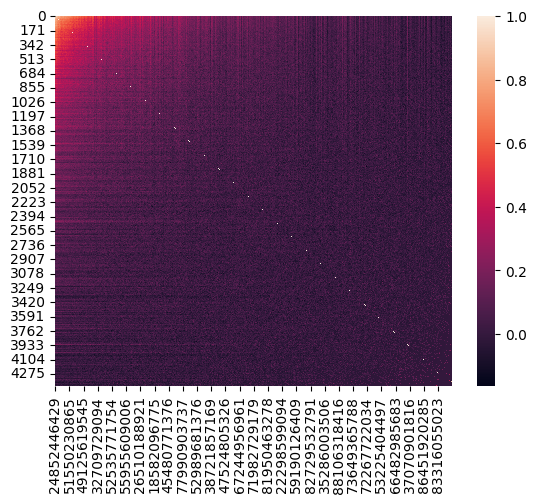

In [62]:
correlations = Statistics.corr(feature_rdd, method="pearson")
# corr_df = spark.createDataFrame(correlations, merchant_columns + ['total_orders'])
# corr_df = corr_df.withColumn('merchant_abn', )
# corr_df.show()
corr_df = pd.DataFrame(correlations, columns=merchant_columns + ['total_orders'])
sns.heatmap(corr_df)

In [81]:
# Notes for report:
# - count of sales increased in holiday period, not average dollar values - try to verify this with correlation of counts?
# - Below shows potential interesting merchants - most are below a certain line

merchant_stats = transactions.groupBy("merchant_abn") \
    .agg(
        F.count("*").alias("count"),
        F.min("dollar_value").alias("min_dollar_value"),
        F.max("dollar_value").alias("max_dollar_value"),
        F.expr("percentile(dollar_value, array(0.25))")[0].alias("q1_dollar_value"),
        F.expr("percentile(dollar_value, array(0.5))")[0].alias("median_dollar_value"),
        F.expr("percentile(dollar_value, array(0.75))")[0].alias("q3_dollar_value"),
        F.expr("mean(dollar_value)").alias("mean_dollar_value"),
        F.skewness("dollar_value").alias("skewness_dollar_value")
    )

merchant_stats.pandas_api().plot.scatter("mean_dollar_value", "count")

In [71]:
# Shows interesting merchants with onle 157 as a dollar value
merchant_stats.sort('skewness_dollar_value', F.col('count').desc()).show(10000)

+------------+------+--------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+
|merchant_abn| count|    min_dollar_value|  max_dollar_value|   q1_dollar_value|median_dollar_value|   q3_dollar_value| mean_dollar_value|skewness_dollar_value|
+------------+------+--------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+
| 24015173965|  6526|               157.0|             157.0|             157.0|              157.0|             157.0|             157.0|                 NULL|
| 43660707274|  4692|               157.0|             157.0|             157.0|              157.0|             157.0|             157.0|                 NULL|
| 65204103269|  4561|               157.0|             157.0|             157.0|              157.0|             157.0|             157.0|                 NULL|
| 66571984047|  4297|             

In [80]:
# merchant_stats.where(F.col("count") > 500).pandas_api().plot.scatter("mean_dollar_value", "count")
merchant_stats.pandas_api().plot.scatter("mean_dollar_value", "count")

In [82]:
# Displays other interesting merchants
merchant_stats.pandas_api().plot.scatter("count", "skewness_dollar_value")

In [83]:
transactions.where(F.col("merchant_abn") == "64203420245").select("dollar_value").pandas_api().plot.hist()

In [6]:
transactions.where(F.col("merchant_abn") == "64203420245").select("dollar_value", "order_datetime").groupBy("order_datetime").count().sort("order_datetime").pandas_api().plot(x="order_datetime", y="count")

In [38]:
transactions.where(F.col("merchant_abn") == "64203420245").select("postcode").distinct().count()

2636

In [23]:
transactions_df = pd.read_parquet("temp.parquet")
transactions_df

postcode order_datetime  merchant_abn  user_id consumer_id  \
0             6336     2021-11-26   35813492759    15564     1223400   
1             6336     2021-11-26   73972053940    15564     1223400   
2             4101     2021-11-26   64203420245      626      602394   
3             4101     2021-11-26   80324045558      626      602394   
4             2866     2021-11-26   99976658299      802      928233   
...            ...            ...           ...      ...         ...   
11846537      5431     2021-03-01   95492562735    18096      553140   
11846538      3053     2021-03-01   49891706470    18223      980779   
11846539      2706     2021-03-01   39211701585    18344      996253   
11846540      6490     2021-03-01   39869100896    18447      719482   
11846541      6490     2021-03-01   24852446429    18447      719482   

          dollar_value                              order_id  \
0           103.152114  12639bdf-fb76-4b4e-84e9-991a6b98f0f1   
1            40.378401  d93b0262-d0c6-44c5-b912-76760d0142a9   
2            40.364780  a9a6a781-659b-4c99-a29a-0b7b634c1803   
3             0.765264  b8e9cf7d-cba5-4b1c-a433-9bbe28b8ee88   
4           126.743106  c0ea0a59-4a91-427c-8461-9303e795e41e   
...                ...                                   ...   
11846537     65.064510  9b8be1af-f555-4f87-833e-854517265289   
11846538      6.117126  99393362-6fee-4527-bb8f-ca9d6c375268   
11846539    200.940621  3af6f606-eab6-4911-ab93-01cff609e8a6   
11846540     12.309706  5c68370f-eb7a-465b-bf06-cd5c706764dc   
11846541     19.840313  9c237864-6139-4114-a050-a2f2fdcaa930   

               consumer_name state       gender  ...  \
0            Charles Parsons    WA  Undisclosed  ...   
1            Charles Parsons    WA  Undisclosed  ...   
2             Robin Anderson   QLD       Female  ...   
3             Robin Anderson   QLD       Female  ...   
4         Melissa Huffman MD   NSW       Female  ...   
...                      ...   ...          ...  ...   
11846537       Ricky Sanchez    SA         Male  ...   
11846538       Brian Michael   VIC         Male  ...   
11846539       Veronica Cruz   NSW       Female  ...   
11846540        Rachel Evans    WA       Female  ...   
11846541        Rachel Evans    WA       Female  ...   

                                                       tags  \
0         [[opticians, optical goods, and eyeglasses], [...   
1         [[tent and awning shops], [b], [take rate: 3.88]]   
2         [[tent and awning shops], [c], [take rate: 2.86]]   
3         [[gift, card, novelty, and souvenir shops], [c...   
4                   [[shoe  shops], [a], [take rate: 6.57]]   
...                                                     ...   
11846537                                               None   
11846538  [[tent and awning shops], [a], [take rate: 5.80]]   
11846539             [[shoe shops], [b], [take rate: 4.76]]   
11846540  [[digital goods: books, movies, music], [b], [...   
11846541  [[florists supplies, nursery stock, and flower...   

                                              tags1 tags2 tags3  \
0              opticians, optical goods, eyeglasses     a  5.66   
1                                      tent, awning     b  3.88   
2                                      tent, awning     c  2.86   
3                     gift, card, novelty, souvenir     c  1.47   
4                                              shoe     a  6.57   
...                                             ...   ...   ...   
11846537                                       None  None   NaN   
11846538                               tent, awning     a  5.80   
11846539                                       shoe     b  4.76   
11846540        digital goods, books, movies, music     b  5.09   
11846541  florists supplies, nursery stock, flowers     c  2.94   

         merchant_fraud_probability  AREASQKM21  SHAPE_Leng  SHAPE_Area  \
0                               NaN   2355.7587    2.532377    0.2

In [87]:
from prophet import Prophet

transactions_df = pd.read_parquet("temp.parquet")

transactions_df['ds'] = transactions_df['order_datetime']
transactions_df['y'] = transactions_df['dollar_value']
m = Prophet()
m.fit(transactions_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/tmpfgf33hh8/h2y3wb6c.json
DEBUG:cmdstanpy:input tempfile: /var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/tmpfgf33hh8/wzqom7j5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/project-2-group-buy-now-pay-later-industry-project-30/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69006', 'data', 'file=/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/tmpfgf33hh8/h2y3wb6c.json', 'init=/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/tmpfgf33hh8/wzqom7j5.json', 'output', 'file=/var/folders/xv/sxpnj6zd667gmqqstx378

/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/project-2-group-buy-now-pay-later-industry-project-30/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/project-2-group-buy-now-pay-later-industry-project-30/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



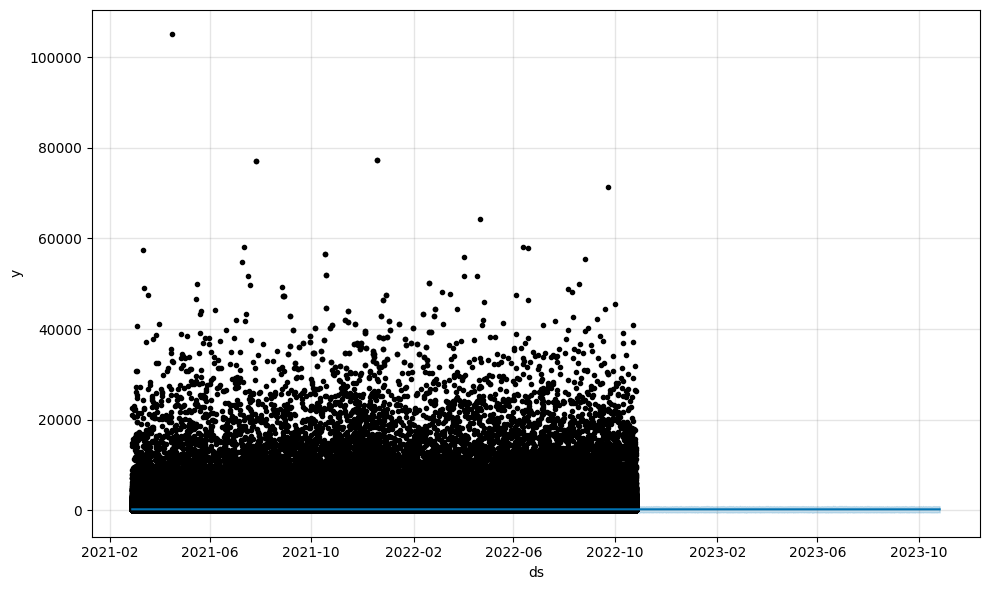

In [88]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

torch.Size([14, 30, 1])
torch.Size([14, 30, 2])
